In [1]:
import json
import copy

import numpy
import matplotlib
from matplotlib import pyplot
import pyhf

import blind
import jsongz

In [2]:
import jax
import scipy.optimize

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)
pyhf.set_backend("jax")

In [3]:
SPEC = jsongz.load("ins1852821_bkg.json.gz")
# SPEC = jsongz.load("ins1852821_signal.json.gz")

In [4]:
[channel["name"] for channel in SPEC["channels"]]

['SR0bvetoloose_cuts',
 'SR0bvetotight_cuts',
 'SR0breq_cuts',
 'SR1bvetoloose_cuts',
 'SR1bvetotight_cuts',
 'SR1breq_cuts',
 'SR2bvetoloose_cuts',
 'SR2bvetotight_cuts',
 'SR2breq_cuts',
 'SR0ZZloose_cuts',
 'SR0ZZtight_cuts',
 'SR0ZZbvetoloose_cuts',
 'SR0ZZbvetotight_cuts',
 'SR5L_cuts',
 'CRZZ_cuts',
 'CRttZ_cuts']

In [5]:
SR_NAME = "SR0bvetotight_cuts"
# SR_NAME = "SR0ZZloose_cuts"
# SR_NAME = "SR0ZZtight_cuts"
# SR_NAME = "SR0ZZbvetotight_cuts"
# atlas_susy_4l presents yields without SR constraints
# (sensibly, but violating ATLAS SUSY policy)

In [6]:
def get_named(seq, name):
    for item in seq:
        if item["name"] == name:
            return item
    raise KeyError(name)

In [7]:
def add_signal(
    spec,
    channel_name,
    measurement_name="NormalMeasurement",
    poi_name="mu_SIG",
):
    # add a dummy signal to its channel
    channel = get_named(spec["channels"], channel_name)

    channel["samples"].append({
        "data": [0.0],
        "modifiers": [{
            "data": None,
            "name": poi_name,
            "type": "normfactor", 
        }],
        "name": "signal",
    })
    
    # add a its modifier name to the measurement
    measurement = get_named(spec["measurements"], measurement_name)
    measurement["config"]["parameters"].append({
        "bounds": [[0.0, 2.0]],
        "fixed": False,
        "inits": [1.0],
        "name": poi_name,
    })
    measurement["config"]["poi"] = poi_name
    
    return spec

In [8]:
def make_model_and_data(spec, signal_channel_name):
    spec = copy.deepcopy(spec)
    spec = add_signal(spec, signal_channel_name)
    workspace = pyhf.workspace.Workspace(spec)
    
    channels_keep = {
        signal_channel_name,
        # TODO arguments?
        "CRZZ_cuts",
        "CRttZ_cuts",
    }
        
    channels_prune = workspace.channel_slices.keys() - channels_keep
    
    workspace_pruned = workspace.prune(channels=channels_prune)
    
    model = workspace_pruned.model()
    data = numpy.array(workspace_pruned.data(model))
    
    return model, data


MODEL, DATA = make_model_and_data(SPEC, SR_NAME)

In [9]:
def test_logpdf(model, data, signal_channel_name):
    parameters = numpy.array(model.config.suggested_init())
    
    print(model.logpdf(parameters, data))
    
    print(blind.model_logpdf_blind(model, parameters, data, []))
    
    logf = blind.model_logpdf_blind(model, parameters, data, {signal_channel_name})
    print(logf)

    slice_ = model.config.channel_slices[signal_channel_name]
    expected_data = model.expected_actualdata(parameters)
    mu = expected_data[slice_]
    nobs = data[slice_]
    print(mu, nobs)

    loglikelihood = pyhf.probability.Poisson(mu).log_prob(numpy.array(nobs))
    print(loglikelihood)
    print(logf + loglikelihood)


test_logpdf(MODEL, DATA, SR_NAME)

[-105.12972977]
[-105.12972977]
[-102.92482288]
[3.4405334] [1.]
[-2.20490689]
[-105.12972977]


In [10]:
def test_hess():
    def f(x):
        return 0.5 * x ** 2
    
    print(jax.hessian(f)(0.1))
    
test_hess()

1.0


In [11]:
def inner_product(x, c):
    return x.dot(c.dot(x))

In [12]:
def d2fdx2(fminus, f, fplus, eps):
    return ((fplus - f) - (f - fminus)) / eps ** 2

In [13]:
def test_opt(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    print(fjit(parameters)[0])

    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
        options=dict(ftol=1e-10, gtol=1e-10),
    )
    
    print(result)
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    print(y(parameters))
    print(y(result.x))
    
    ygrad = jax.grad(y)(result.x)
    
    def cov_jax(x):
        hess = jax.hessian(f)(x)
        return jax.numpy.linalg.inv(hess)
    
    cov_lbfgs = result.hess_inv.todense()
    cov = numpy.array(cov_jax(result.x))
    
    var_lbfgs = inner_product(ygrad, result.hess_inv)
    var = inner_product(ygrad, cov)
    
    print("std")
    print(var_lbfgs ** 0.5)
    # jax hessian seems to give broken answers - numerical failure?
    print(var ** 0.5)


test_opt(MODEL, DATA, SR_NAME)

102.92482288151945
      fun: 81.11213876564237
 hess_inv: <98x98 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.39478926e-03,  0.00000000e+00,  3.30536636e-05,  1.00885988e-05,
        2.23474201e-06,  1.14710162e-08,  3.92474899e-06,  4.24873226e-06,
        1.57753524e-06, -5.65388035e-06, -6.89217420e-06, -7.40028403e-07,
        2.90810767e-06, -5.39577323e-07, -3.63939255e-05,  6.84889744e-06,
       -7.05333127e-06,  2.38319391e-05,  1.08063747e-08,  1.43309912e-08,
       -8.18904776e-07,  2.85837305e-05, -1.89794629e-05,  1.73603457e-05,
        5.92145879e-06,  5.72134302e-06,  1.35566138e-05,  3.79703194e-06,
        3.65765978e-06,  1.57560898e-04,  0.00000000e+00, -1.67157205e-06,
       -9.27514731e-07,  1.72118120e-05,  0.00000000e+00,  1.75494492e-06,
        1.67412651e-06, -1.01295206e-05, -7.53167933e-06, -5.34778595e-06,
        1.16291868e-05, -4.08131210e-06, -6.13126045e-06, -6.47914600e-06,
        1.77850241e-05,  1.13733348e-07,  1.64657626e-07, 

In [14]:
def test_opt_q(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}

    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    f_cov = (
        numpy.full([len(parameters), len(parameters)], 1e-1)
        + numpy.eye(len(parameters))
    )
    f_cov_inv = numpy.linalg.inv(f_cov)
    f_mu = numpy.full(len(parameters), 0.1)
    
    def f(x):
        return 0.5 * inner_product(x - f_mu, jax.numpy.array(f_cov_inv))
    
    fjit = jax.jit(jax.value_and_grad(f))
    
    print(fjit(parameters)[0])

    result = scipy.optimize.minimize(
        fjit,
        parameters,
        # bounds=bounds,
        jac=True,
        method="L-BFGS-B",
        options=dict(ftol=1e-10, gtol=1e-10),
    )
    
    print(result)
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    y_proj = numpy.linspace(0, 1, len(parameters))
    
    def y(x):
        return x.dot(y_proj)
    
    print(y(parameters))
    print(y(result.x))
    
    ygrad = jax.grad(y)(result.x)
    
    def cov_jax(x):
        hess = jax.hessian(f)(x)
        return jax.numpy.linalg.inv(hess)
    
    cov_lbfgs = result.hess_inv.todense()
    cov = numpy.array(cov_jax(result.x))
    
    print("cov_det")
    print(numpy.linalg.det(cov_lbfgs))
    print(numpy.linalg.det(cov))
    
    var_lbfgs = inner_product(ygrad, result.hess_inv)
    var = inner_product(ygrad, cov)
    
    print("std")
    print(var_lbfgs ** 0.5)
    print(var ** 0.5)
    print(inner_product(y_proj, f_cov) ** 0.5)
    
    print(inner_product(ygrad, numpy.linalg.inv(cov)), inner_product(ygrad, cov))
    
    # try numerical derivatives
    eps = 1e-1
    fplus = f(result.x + eps * ygrad * var ** 0.5)
    fminus = f(result.x - eps * ygrad * var ** 0.5)
    
    print(fminus, result.fun, fplus)
    return
    
    print("d2fdx2")
    hess = d2fdx2(fminus, result.fun, fplus, eps)
    print(hess)
    
    print((numpy.diff([fminus, result.fun, fplus], n=2) / eps ** 2) ** -0.5)
    
    delta = float(fplus - result.fun)
    print(f"{delta=}")
    var = 0.5 * eps ** 2 / delta
    print(var ** 0.5, 1 / var ** 0.5)


test_opt_q(MODEL, DATA, SR_NAME)

4.489814814814816
      fun: 4.938390223750724e-25
 hess_inv: <98x98 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.08497049e-13,  5.85709721e-13, -3.34200260e-14, -3.59457834e-14,
       -1.87512043e-14, -3.74029511e-14, -3.74168289e-14, -2.67448101e-14,
       -2.67448101e-14, -1.34221338e-14, -1.74189367e-14, -3.34061482e-14,
       -1.74189367e-14, -4.00813642e-14, -3.20877584e-14, -2.14157396e-14,
       -2.14296173e-14, -1.34221338e-14, -2.67448101e-14, -2.14157396e-14,
       -2.14157396e-14, -2.14157396e-14, -1.34221338e-14, -2.14157396e-14,
       -1.07575985e-14, -1.07575985e-14, -1.74189367e-14, -1.74189367e-14,
       -1.34221338e-14, -9.42533089e-15, -1.07575985e-14, -1.47544014e-14,
        2.65597729e-14,  4.52253975e-14,  3.45672565e-14,  4.52253975e-14,
        3.72317917e-14,  4.25608622e-14,  4.52253975e-14,  4.25469845e-14,
        1.05725613e-14,  1.05725613e-14,  1.05725613e-14,  2.56507778e-15,
        5.24349083e-15,  9.24029372e-15,  5.22961304e-1

# optimize with constraints

In [15]:
def piecewise_linear_roots(f, x):
    """Return a list of points for which f(x) = 0 in a linear interpolation."""
    results = []
    for f1, f2, x1, x2 in zip(f[:-1], f[1:], x[:-1], x[1:]):
        # root implies that f1 f2 change sign
        if not f1 * f2 <= 0:
            continue
        # zero step special case
        if x1 == x2:
            if f1 == 0:
                results.append(x1)
            continue
        # zero change special case
        if f1 == f2:
            if f1 == 0:
                # panic! entire line segment is a root
                results.append(numpy.nan)
            continue
        # approx f = f1 + (x - x1) * (f2 - f1) / (x2 - x1)
        #          = f1 + (x - x1) * dfdx
        # f = 0 =>
        #        x = x1 + (0 - f1) / dfdfx
        xroot = x1 - f1 * (x2 - x1) / (f2 - f1)
        results.append(xroot)
    return results

f =  81.11213938283987
y =  3.52361816023076
f =  81.13650134321668
y =  3.999999941377592
0.0 85.48754626821457
1.0 83.3374939055901
2.0 81.5529216178601
3.0 81.14965233737591
4.0 81.13650134321668
5.0 81.30486231033403
6.0 81.5736363708307
7.0 81.90427196684664
8.0 82.27577930702309
9.0 82.67559802362508
10.0 83.09568260745094
11.0 83.5306117547507
12.0 83.97658626259017
13.0 84.43085961690434
14.0 84.89139543907528
15.0 85.35665258905902
16.0 85.8254440501482
17.0 86.2968420554337
18.0 86.77011358005892
19.0 87.2446727221866
20.0 87.72004939192425


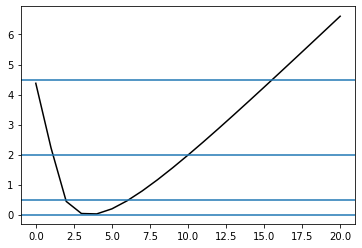

/tmp/ipykernel_61039/2168905015.py:90: RuntimeWarning: divide by zero encountered in log
  pyplot.plot(numpy.log(ypoints), fs - result.fun, "k")


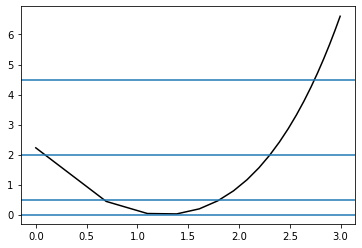

[1.966816830348126, 6.116451502721191]


In [16]:
def test_opt_constrain(model, data, signal_channel_name):
    blind_bins = {signal_channel_name}
    
    # optimization
    def f(x):
        logy, = blind.model_logpdf_blind(model, x, data, blind_bins)
        return -logy
    
    fjit = jax.jit(jax.value_and_grad(f))
          
    parameters = numpy.array(model.config.suggested_init())
    bounds = numpy.array(model.config.suggested_bounds())
    
    result = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="L-BFGS-B",
    )
    
    # SR yields
    slice_ = model.config.channel_slices[signal_channel_name]
    
    def y(x):
        expected_data = model.expected_actualdata(x)
        yres, = expected_data[slice_]
        return yres
    
    yjit = jax.jit(y)
    
    print("f = ", result.fun)
    print("y = ", yjit(result.x))
    
    # constrain
    ygrad = jax.jit(jax.grad(y))
    
    yfix = 4.0
    fix = scipy.optimize.NonlinearConstraint(y, yfix, yfix, jac=ygrad)
        
    result2 = scipy.optimize.minimize(
        fjit,
        parameters,
        bounds=bounds,
        jac=True,
        method="SLSQP",
        constraints=fix,
    )

    print("f = ", result2.fun)
    print("y = ", yjit(result2.x))
    
    # scan
    def fmax_given_yfix(yfix):
        fix = scipy.optimize.NonlinearConstraint(
            y, 
            yfix, 
            yfix, 
            jac=ygrad,
        )

        result = scipy.optimize.minimize(
            fjit,
            parameters,
            bounds=bounds,
            jac=True,
            method="SLSQP",
            constraints=fix,
        )
        
        return result.fun
    
    ypoints = numpy.linspace(0., 20., 21)
    
    fs = []
    for yfix in ypoints:
        fmax = fmax_given_yfix(yfix)
        print(yfix, fmax)
        fs.append(fmax)
        
    fs = numpy.array(fs)
    
    pyplot.plot(ypoints, fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.plot
    pyplot.show()   
    
    pyplot.plot(numpy.log(ypoints), fs - result.fun, "k")
    for sigma in (0, 1, 2, 3):
        fsigma = 0.5 * sigma ** 2
        pyplot.axhline(fsigma)
    pyplot.plot
    pyplot.show()
    
    print(piecewise_linear_roots(fs - result.fun - 0.5, ypoints))
        


test_opt_constrain(MODEL, DATA, SR_NAME)

In [17]:
def print_fit_stuff():
    lo, hi = 1.9298807623648533,  6.124326748041917
    mid = 3.52361816023076
    
    err_lo = mid - lo
    err_hi = hi - mid
    print("%.1f +%.1f -%.1f" % (mid, err_lo, err_hi))

print_fit_stuff()

3.5 +1.6 -2.6
